[View in Colaboratory](https://colab.research.google.com/github/stoiver/anuga-clinic-2018/blob/master/install_anuga.ipynb)

# CSDMS ANUGA Clinic 2018

## Install ANUGA

Run the following cell to install ANUGA on Colaboratory. 

Wait until you see the comment *(5) Ready to go* before proceeding to subsequent commands. 
The install should take less than a minute.

In [1]:
print "(1) Install netcdf nose via pip"
!pip -q install netCDF4 nose  > /dev/null 2>&1 
print "(2) Install gdal via apt-get"
!apt-get -q -y install python-gdal gdal-bin  > /dev/null 2>&1 

print "(3) Download anuga_core github repository"
!git clone --quiet https://github.com/GeoscienceAustralia/anuga_core.git  > /dev/null 2>&1 
print "(4) Install anuga"
import os
os.chdir('anuga_core')
!python setup.py --quiet install  > /dev/null 2>&1 
os.chdir('../')
print "(5) Ready to go"

(1) Install netcdf nose via pip
(2) Install gdal via apt-get
(3) Download anuga_core github repository
(4) Install anuga
(5) Ready to go


## Import ANUGA and other libraries into notebook

Allows us access to `anuga` and inline plotting. Also we have a work around to ensure we recover output to the notebook after the import of `netcdf`.

In [2]:
#import sys
#stdout = sys.stdout

import anuga

# NetCDF changes stdout to the terminal
# This resets it
#reload(sys)
#sys.stdout = stdout


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Allow inline make_depth_animations
from matplotlib import rc
rc('animation', html='jshtml')




## Create an ANUGA domain

A `domain` is the core object which contains the mesh and the quantities for the particular problem. Here we create a simple rectangular domain. We set the name to `channel1` which will be used when storing the simulation output to a `sww` file called `channel1.sww`.

In [3]:
domain = anuga.rectangular_cross_domain(40, 20, len1=20.0, len2=10.0)
domain.set_name('channel1')

Let's look at the mesh.

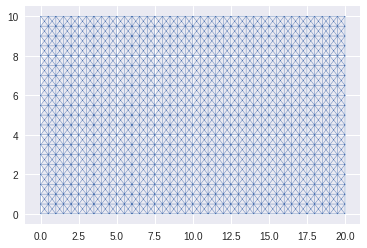

In [11]:
class Jupyter_plotter:
  
  def __init__(self, domain):
    
    import matplotlib.tri as tri
    self.nodes = domain.nodes
    self.triangles = domain.triangles

    self.triang = tri.Triangulation(self.nodes[:,0], self.nodes[:,1], self.triangles)
    
    self.elev  = domain.quantities['elevation'].centroid_values
    self.depth = domain.quantities['height'].centroid_values
    self.stage = domain.quantities['stage'].centroid_values
    self.xmom  = domain.quantities['xmomentum'].centroid_values
    self.ymom  = domain.quantities['ymomentum'].centroid_values
    self.domain = domain
    
  def _make_depth_vis(self, figsize, dpi):
  
    name = self.domain.get_name()
    time = self.domain.get_time() 

    fig = plt.figure(figsize=figsize, dpi=dpi)

    plt.title('Time {0:0>4}'.format(time))
    
    self.triang.set_mask(self.depth>0.01)
    plt.tripcolor(self.triang, 
              facecolors = self.elev,
              cmap='Greys_r')
    
    self.triang.set_mask(self.depth<0.01)
    plt.tripcolor(self.triang, 
              facecolors = self.depth,
              cmap='viridis')

    plt.colorbar()
    
    return    
    
  def make_depth_png(self):

    figsize=(10,6)
    dpi = 80
    name = self.domain.get_name()
    time = self.domain.get_time()

    self._make_depth_vis(figsize,dpi);
    
    plt.savefig(name+'_{0:0>4}.png'.format(int(time)))
    plt.close()
    
    return    

  def make_depth_plot(self):
  
    figsize=(5,3)
    dpi = 80
    
    self._make_depth_vis(figsize,dpi)
    
    plt.show()
    
    return

  def make_depth_animation(domain):
    import numpy as np
    import glob
    from matplotlib import image, animation
    from matplotlib import pyplot as plt

    
    img_files = sorted(glob.glob("channel1_*.png"))

    figsize=(10,6)

    fig = plt.figure(figsize=figsize, dpi=80)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')  # so there's not a second set of axes
    im = plt.imshow(image.imread(img_files[0]))

    def init():
      im.set_data(image.imread(img_files[0]))
      return im,

    def animate(i):
      image_i=image.imread(img_files[i])
      im.set_data(image_i)
      return im,

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                            frames=len(img_files), interval=200, blit=True)

    plt.close()
  
    return anim
  
    
dplotter = Jupyter_plotter(domain)  
    

plt.triplot(dplotter.triang, linewidth = 0.4);

## Setup Initial Conditions

We have to setup the values of various quantities associated with the domain. In particular we need to setup the `elevation` the elevation of the bed or the bathymetry. In this case we will do this using a function. 

In [12]:
def topography(x, y):

    z = -x/10

    N = len(x)
    
    minx = np.floor(np.max(x)/4)
    stepx1 = np.min(x[(x >= minx)])
    stepx2 = np.min(x[(x > stepx1 + 0.25)])
    
    minx = np.floor(np.max(x)/2)
    stepx3 = np.min(x[(x >= minx)])
    stepx4 = np.min(x[(x > stepx3 + 0.25)])
    
    minx = np.floor(3*np.max(x)/4)
    stepx5 = np.min(x[(x >= minx)])
    stepx6 = np.min(x[(x > stepx5 + 0.25)])
    
    dist = 0.4 * (np.max(y) - np.min(y))
    
    for i in range(N):
        if stepx1 <= x[i] <= stepx2:
            if (y[i] < dist):
                z[i] += 2
                
        if stepx3 <= x[i] <= stepx4:
            if (y[i] > np.max(y) - dist):
                z[i] += 2
                
        if stepx5 <= x[i] <= stepx6:
            if (y[i] < dist):
                z[i] += 2
            
    return z

### Set Quantities

Now we set the `elevation`, `stage` and `friction` using the `domain.set_quantity` function. 

In [13]:
domain.set_quantity('elevation', topography, location='centroids') # Use function for elevation
domain.set_quantity('friction', 0.01, location='centroids')        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids') # Dry Bed 

### View Elevation

Let's use the `matplotlib` function `tripcolor` to plot the `elevation` quantitiy.  We access the `elevation` quantity using `domain.quantities['elevation']`. 

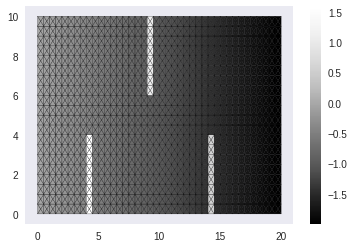

In [14]:
plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              edgecolors='k', 
              cmap='Greys_r')
plt.colorbar();



## Setup Boundary Conditions

The rectangular domain has 4 tagged boundaries, left, top, right and bottom. We need to set boundary conditons for each of these tagged boundaries. We can set Dirichlet type BC with specified values of stage, and x and y "momentum". Another common BC is `Reflective_boundary` which mimic a wall. 

In [15]:
Bi = anuga.Dirichlet_boundary([0.4, 0, 0])         # Inflow
Bo = anuga.Dirichlet_boundary([-2, 0, 0])          # Inflow
Br = anuga.Reflective_boundary(domain)             # Solid reflective wall

domain.set_boundary({'left': Bi, 'right': Bo, 'top': Br, 'bottom': Br})

## Run the Evolution

We evolve using a `for` statement, which evolves the quantities using the shallow water wave solver. The calculation `yields` every `yieldstep` seconds, up to a given `duration`.

In [18]:



for t in domain.evolve(yieldstep=5, duration=40):
  
    #dplotter.make_depth_plot()
    dplotter.make_depth_png()
    
    domain.print_timestepping_statistics()

    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation() 

Time = 85.0000, delta t in [0.01239885, 0.01241175], steps=404 (24s)
Time = 90.0000, delta t in [0.01240164, 0.01240237], steps=404 (1s)
Time = 95.0000, delta t in [0.01239946, 0.01240190], steps=404 (1s)
Time = 100.0000, delta t in [0.01239688, 0.01239958], steps=404 (1s)
Time = 105.0000, delta t in [0.01239671, 0.01239744], steps=404 (1s)
Time = 110.0000, delta t in [0.01239635, 0.01239743], steps=404 (1s)
Time = 115.0000, delta t in [0.01239534, 0.01239646], steps=404 (1s)
Time = 120.0000, delta t in [0.01239646, 0.01240439], steps=404 (1s)


In [0]:
!rm None*.png

In [0]:
ls

In [0]:
!rm *.png

In [19]:
 dplotter.make_depth_animation()
